# Step 0: Explore the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<AxesSubplot:>

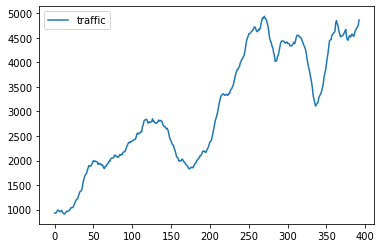

In [1]:
import pandas as pd
df = pd.read_csv('website_data.csv')
df.info()

df.plot()

<AxesSubplot:>

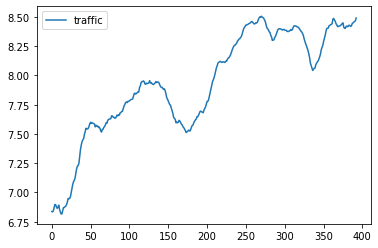

In [2]:
import numpy as np
df = np.log(df) # don't forget to transform the data back when making real predictions

df.plot()

In [3]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

# Step 1: Check for stationarity of time series

## Method #1: time series plot

## Method #2: ACF plot and PACF plot

C:\Users\liann\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


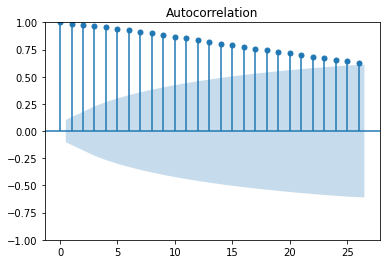

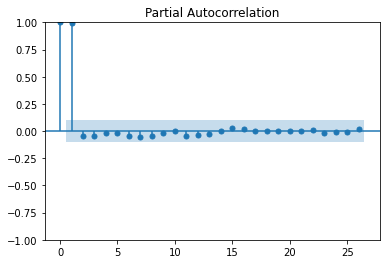

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test

In [5]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.24126116082883903


## Transform to stationary: differencing

<AxesSubplot:>

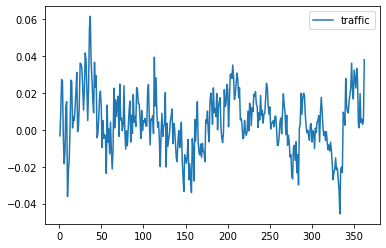

In [6]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

C:\Users\liann\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


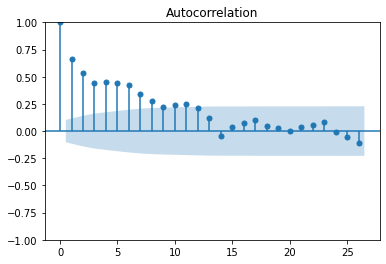

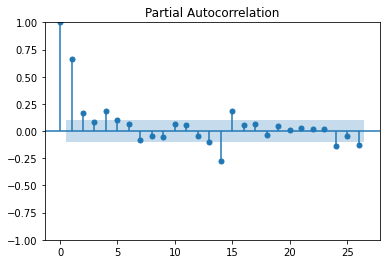

In [7]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [8]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.022059461239126152


# Step 2: Determine ARIMA models parameters p, q

# Step 3: Fit the ARIMA model

In [9]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Sun, 04 Sep 2022   AIC                          -2186.737
Time:                        16:38:12   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

# Step 4: Make time series predictions

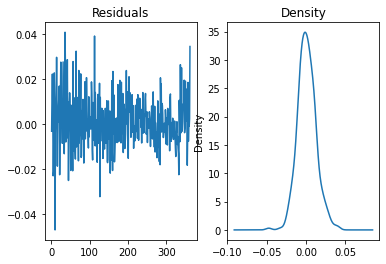

In [10]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\liann\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


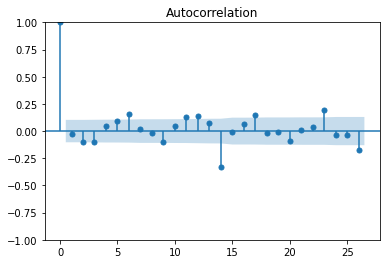

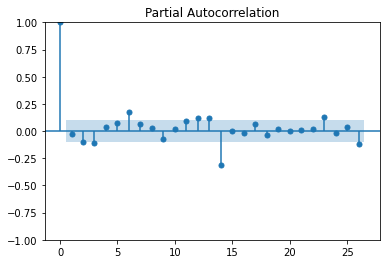

In [11]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<AxesSubplot:>

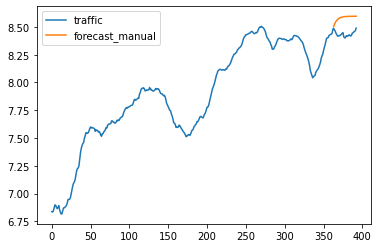

In [12]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# Optional: Auto-fit the ARIMA model

In [13]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [14]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.359
Date:                Sun, 04 Sep 2022   AIC                          -2200.719
Time:                        16:41:48   BIC                          -2173.477
Sample:                             0   HQIC                         -2189.889
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.509      0.131      -0.000       0.002
ar.L1          0.5213      0.052      9.978      0.000       0.419       0.624
ar.L2          0.0938      0.065      1.440      0.150      -0.034       0.221
ar.L3         -0.0362      0.064     -0.564      0.573      -0.162       0.090
ar.L4          0.1288      0.053      2.431      0.015       0.025       0.233
ar.L5          0.1009      0.049      2.045      0.041       0.004       0.198
sigma2         0.0001   8.59e-06     14.964      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.88
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate model predictions

<AxesSubplot:>

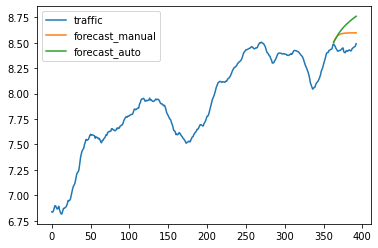

In [15]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.14514968388076604
mape - manual: 0.017216198515850756
rmse - manual: 0.15051403899106064


In [17]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.21701199293639092
mape - auto: 0.025732742863908743
rmse - auto: 0.2313024737299977


# Other suggestions